In [ ]:
# 1. Setup & Imports
import os                               # File system operations
import pandas as pd                     # Data handling
import numpy as np                      # Numerical operations
import matplotlib.pyplot as plt         # Plotting
from matplotlib.collections import LineCollection
import seaborn as sns                   # Advanced visualization
import yfinance as yf                   # Fetch stock data
import pandas_market_calendars as mcal  # Market trading calendar
from datetime import datetime
from scipy import stats                 # Z-score / statistical functions
%matplotlib inline 
import plotly.graph_objects as go

# Display & Plotting settings
pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8")
# sns.set_palette("Set2")  # Consistent color theme

# 2. Configuration
CONFIG = {
    "tickers": ["AAPL", "MSFT", "GOOGL", "JPM", "TSLA"],  # Tech, Finance, Auto
    "start_date": "2022-01-01",
    "end_date": "2025-01-01",
    "backup_path": "data/backup_stocks.csv",
    "output_long": "data/cleaned_stock_data_long.csv",
    "output_wide": "data/cleaned_stock_data_wide.csv",
}

TICKERS = CONFIG["tickers"]
START_DATE = CONFIG["start_date"]
END_DATE = CONFIG["end_date"]
BACKUP_PATH = CONFIG["backup_path"]

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
# 3. Data Acquisition
def fetch_stock_data(tickers: list[str], start: str, end: str) -> pd.DataFrame:
    """
    Fetch historical stock data from Yahoo Finance with CSV fallback.
    
    Args:
        tickers (list[str]): List of stock tickers (e.g., ['AAPL', 'MSFT']).
        start (str): Start date (YYYY-MM-DD).
        end (str): End date (YYYY-MM-DD).
    
    Returns:
        pd.DataFrame: Multi-ticker data with multi-level columns.
    """
    try:
        if not tickers:
            raise ValueError("No tickers provided")

        data = yf.download(
            tickers, start=start, end=end,
            group_by="ticker", auto_adjust=True, progress=False
        )

        if data.empty:
            raise ValueError("No data fetched; check tickers or dates")

        print(f"✅ Data fetched successfully for {len(tickers)} tickers "
              f"({start} → {end})")
        return data

    except Exception as e:
        print(f"⚠️ yfinance failed: {e}. Loading backup CSV instead...")
        return pd.read_csv(BACKUP_PATH)


raw_data = fetch_stock_data(TICKERS, START_DATE, END_DATE)
raw_data.head()

✅ Data fetched successfully for 5 tickers (2022-01-01 → 2025-01-01)


Ticker            TSLA                                                 \
Price             Open        High         Low       Close     Volume   
Date                                                                    
2022-01-03  382.583344  400.356659  378.679993  399.926666  103931400   
2022-01-04  396.516663  402.666656  374.350006  383.196655  100248300   
2022-01-05  382.216675  390.113342  360.336670  362.706665   80119800   
2022-01-06  359.000000  362.666656  340.166656  354.899994   90336600   
2022-01-07  360.123322  360.309998  336.666656  342.320007   84164700   

Ticker            AAPL                                                 \
Price             Open        High         Low       Close     Volume   
Date                                                                    
2022-01-03  174.345053  179.296091  174.227410  178.443130  104487900   
2022-01-04  179.050994  179.354917  175.609770  176.178406   99310400   
2022-01-05  176.090142  176.639165  171.217539  171.492050   94537600   
2022-01-06  169.315613  171.864667  168.276388  168.629333   96904000   
2022-01-07  169.501897  170.727401  167.678346  168.796005   86709100   

Ticker            MSFT                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2022-01-03  325.086189  327.655077  319.686659  324.504547  28865100   
2022-01-04  324.582158  324.940858  316.138745  318.940308  32674300   
2022-01-05  315.886642  316.090236  306.309056  306.696808  40054300   
2022-01-06  303.565678  308.945831  301.956480  304.273346  39646100   
2022-01-07  304.535055  306.813137  300.599319  304.428436  32720000   

Ticker             JPM                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2022-01-03  144.626404  147.141488  144.309752  146.291061  13120900   
2022-01-04  148.652328  152.515429  148.579950  151.836899  20195800   
2022-01-05  152.737920  153.229384  149.015480  149.060989  17539400   
2022-01-06  151.909718  152.328369  149.142916  150.644638  14047500   
2022-01-07  150.781140  152.473981  150.225960  152.137238  13913300   

Ticker           GOOGL                                                
Price             Open        High         Low       Close    Volume  
Date                                                                  
2022-01-03  144.061378  144.851931  142.728576  143.998322  28646000  
2022-01-04  144.400050  145.481595  142.732065  143.410385  28400000  
2022-01-05  143.430740  143.509694  136.744859  136.831253  54618000  
2022-01-06  136.060077  138.981426  135.623089  136.803940  37348000  
2022-01-07  137.199210  137.500143  134.836508  136.078445  29760000

In [ ]:

# 4. Data Cleaning
def clean_stock_data(df: pd.DataFrame, ticker: str) -> pd.DataFrame:
    """
    Clean stock data for a single ticker.
    
    Steps:
        - Ensure datetime index and sort by date.
        - Handle missing values (drop if >50%, else ffill/bfill).
        - Drop duplicates and enforce numeric dtypes.
        - Validate constraints (non-negative prices, valid dates).
    
    Args:
        df (pd.DataFrame): Raw data with Date, Open, High, Low, Close, Volume.
        ticker (str): Stock ticker symbol.
    
    Returns:
        pd.DataFrame: Cleaned dataset with 'Ticker' column added.
    """
    df = df.copy()
    df.reset_index(inplace=True)
    df["Ticker"] = ticker

    # Validate inputs
    if df.empty or "Date" not in df:
        raise ValueError(f"❌ No data or missing Date column for {ticker}")
    if (df[["Open", "High", "Low", "Close"]] < 0).any().any():
        raise ValueError(f"❌ Negative prices detected for {ticker}")

    # Ensure datetime and sort
    df["Date"] = pd.to_datetime(df["Date"]).dt.normalize()
    df.sort_values("Date", inplace=True)

    # Handle missing values (drop if >50% columns missing, else fill)
    missing_pct = df[["Open", "High", "Low", "Close", "Volume"]].isnull().mean(axis=1)
    df = df[missing_pct < 0.5]  # Drop rows with excessive missing values
    df = df.ffill().bfill()  # Forward/backward fill for remaining

    # Drop duplicates
    df.drop_duplicates(subset=["Date"], inplace=True)
    
    # Ensure numeric types
    numeric_cols = ["Open", "High", "Low", "Close", "Volume"]
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    
    return df

# Apply cleaning across tickers
cleaned_list = []
for ticker in TICKERS:
    try:
        temp = raw_data[ticker].reset_index()
        temp = clean_stock_data(temp, ticker)
        cleaned_list.append(temp)
        print(f"✅ {ticker} cleaned successfully ({len(temp)} rows).")
    except Exception as e:
        print(f"⚠️ Error processing {ticker}: {e}")

cleaned_data = pd.concat(cleaned_list, ignore_index=True)

# Drop any stray index column if exists
if "index" in cleaned_data.columns:
    cleaned_data.drop(columns=["index"], inplace=True)

print(f"📊 Final cleaned dataset shape: {cleaned_data.shape}")

✅ AAPL cleaned successfully (753 rows).
✅ MSFT cleaned successfully (753 rows).
✅ GOOGL cleaned successfully (753 rows).
✅ JPM cleaned successfully (753 rows).
✅ TSLA cleaned successfully (753 rows).
📊 Final cleaned dataset shape: (3765, 7)


In [ ]:
# 5. Align with Trading Days
def align_with_trading_days(df: pd.DataFrame, start: str, end: str) -> pd.DataFrame:
    """
    Align stock data with official NYSE trading days.
    
    Args:
        df (pd.DataFrame): Cleaned stock data with 'Date' column.
        start (str): Start date.
        end (str): End date.
    
    Returns:
        pd.DataFrame: Data filtered to valid NYSE trading days.
    """
    nyse = mcal.get_calendar("NYSE")
    schedule = nyse.schedule(start_date=start, end_date=end)
    trading_days = schedule.index.normalize()

    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"]).dt.normalize()
    df = df[df["Date"].isin(trading_days)]

    print(f"✅ Data aligned with NYSE trading days "
          f"({trading_days.min().date()} → {trading_days.max().date()})")
    return df


cleaned_data = align_with_trading_days(cleaned_data, START_DATE, END_DATE)

✅ Data aligned with NYSE trading days (2022-01-03 → 2024-12-31)


In [ ]:
# 6. Outlier Detection
def detect_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """
    Detect outliers in daily returns using Z-score and IQR.
    
    Adds:
        - Daily_Return
        - Z_Score
        - Outlier_Z
        - Outlier_IQR
    
    Args:
        df (pd.DataFrame): Cleaned stock data with Ticker, Date, Close.
    
    Returns:
        pd.DataFrame: Original data with outlier columns.
    """
    df = df.copy()
    
    # Daily returns
    df["Daily_Return"] = df.groupby("Ticker")["Close"].pct_change()

    # Z-score method
    df["Z_Score"] = df.groupby("Ticker")["Daily_Return"].transform(
        lambda x: stats.zscore(x, nan_policy="omit")
    )
    df["Outlier_Z"] = df["Z_Score"].abs() > 3

    # IQR method
    def iqr_outliers(series):
        q1, q3 = np.nanpercentile(series, [25, 75])
        iqr = q3 - q1
        return (series < (q1 - 1.5 * iqr)) | (series > (q3 + 1.5 * iqr))

    df["Outlier_IQR"] = df.groupby("Ticker")["Daily_Return"].transform(iqr_outliers)

    print("✅ Outlier detection completed (Z-score & IQR).")
    return df


cleaned_data = detect_outliers(cleaned_data)

✅ Outlier detection completed (Z-score & IQR).


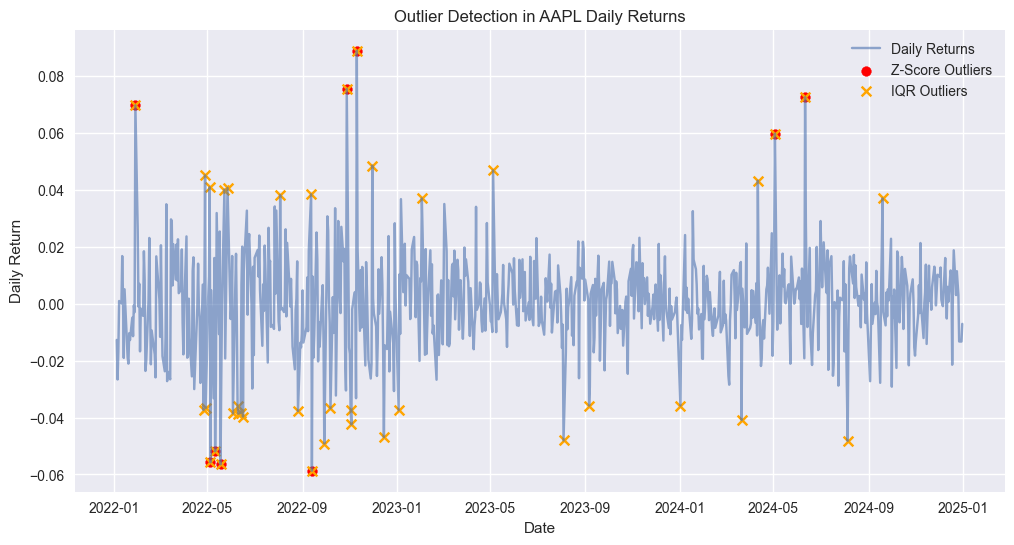

In [ ]:
# 7. Outlier Visualization 
def plot_outliers(df: pd.DataFrame, tickers: list[str] | str):
    """
    Plot daily returns and highlight outliers for one or more tickers.

    Args:
        df (pd.DataFrame): Data with 'Date', 'Daily_Return', 'Outlier_Z', 'Outlier_IQR', 'Ticker'.
        tickers (list[str] | str): Single ticker or list of tickers to plot.
    """
    if isinstance(tickers, str):
        tickers = [tickers]

    for ticker in tickers:
        subset = df[df["Ticker"] == ticker]
        plt.figure(figsize=(12, 6))
        plt.plot(subset["Date"], subset["Daily_Return"], label="Daily Returns", alpha=0.6)
        plt.scatter(subset["Date"][subset["Outlier_Z"]],
                    subset["Daily_Return"][subset["Outlier_Z"]],
                    color="red", label="Z-Score Outliers")
        plt.scatter(subset["Date"][subset["Outlier_IQR"]],
                    subset["Daily_Return"][subset["Outlier_IQR"]],
                    color="orange", marker="x", label="IQR Outliers")

        plt.title(f"Outlier Detection in {ticker} Daily Returns")
        plt.xlabel("Date")
        plt.ylabel("Daily Return")
        plt.legend()
        plt.show()



# Example: Plot for all tickers in a loop
plot_outliers(cleaned_data, ["AAPL"]) 
# plot_outliers(cleaned_data, ["AAPL", "JPM"])  # Tech & Finance examples

In [ ]:
# 8. Data Quality Report
def data_quality_report(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate a data quality report per ticker including:
        - Row count
        - Date range
        - Missing values %
        - Duplicates
        - Outliers %
        - Trading days coverage %

    Args:
        df (pd.DataFrame): Cleaned stock data with Ticker, Date, Close, etc.

    Returns:
        pd.DataFrame: Summary report per ticker.
    """
    core_cols = ["Open", "High", "Low", "Close", "Volume"]
    report = []
    nyse = mcal.get_calendar("NYSE")

    for ticker, group in df.groupby("Ticker"):
        total_rows = len(group)
        missing_pct = (group[core_cols].isnull().sum().sum() / (total_rows * len(core_cols))) * 100
        duplicates = group.duplicated(subset=["Date"]).sum()
        min_date, max_date = group["Date"].min(), group["Date"].max()
        outlier_pct = group["Outlier_Z"].mean() * 100 if "Outlier_Z" in group else np.nan

        # Expected trading days
        schedule = nyse.schedule(start_date=min_date, end_date=max_date)
        expected_days = len(schedule)
        coverage_pct = (total_rows / expected_days) * 100 if expected_days > 0 else np.nan

        report.append({
            "Ticker": ticker,
            "Rows": total_rows,
            "Date Range": f"{min_date.date()} → {max_date.date()}",
            "Missing %": f"{missing_pct:.2f}%",
            "Duplicates": duplicates,
            "Outliers (Z%)": f"{outlier_pct:.2f}%" if not np.isnan(outlier_pct) else "N/A",
            "Trading Days Coverage %": f"{coverage_pct:.2f}%"
        })

    return pd.DataFrame(report)


# Run the report
quality_report = data_quality_report(cleaned_data)
print("📊 Data Quality Report")
display(quality_report)


📊 Data Quality Report


,Ticker,Rows,Date Range,Missing %,Duplicates,Outliers (Z%),Trading Days Coverage %
0,AAPL,753,2022-01-03 → 2024-12-31,0.00%,0,1.20%,100.00%
1,GOOGL,753,2022-01-03 → 2024-12-31,0.00%,0,1.20%,100.00%
2,JPM,753,2022-01-03 → 2024-12-31,0.00%,0,1.33%,100.00%
3,MSFT,753,2022-01-03 → 2024-12-31,0.00%,0,0.93%,100.00%
4,TSLA,753,2022-01-03 → 2024-12-31,0.00%,0,1.20%,100.00%


In [ ]:
# 9. Validation Tests
def validate_preprocessing(df: pd.DataFrame):
    """
    Perform automated checks to ensure preprocessing correctness:
        1. No missing core values
        2. Daily returns computed correctly
        3. Non-negative prices
        4. No duplicate dates
        5. Date ranges within bounds
    """
    # 1. Missing values
    assert df[["Open", "High", "Low", "Close", "Volume"]].isnull().sum().sum() == 0, \
        "❌ Missing values remain!"

    # 2. Daily returns consistency
    for ticker in df["Ticker"].unique():
        subset = df[df["Ticker"] == ticker]
        expected_returns = subset["Close"].pct_change()
        assert np.allclose(subset["Daily_Return"].dropna(), expected_returns.dropna(), equal_nan=True), \
            f"❌ Daily returns mismatch for {ticker}"

    # 3. Non-negative prices
    assert (df[["Open", "High", "Low", "Close"]] >= 0).all().all(), "❌ Negative prices detected!"

    # 4. No duplicates
    for ticker, group in df.groupby("Ticker"):
        assert not group["Date"].duplicated().any(), f"❌ Duplicates found in {ticker}"

    # 5. Date range validation
    for ticker, group in df.groupby("Ticker"):
        assert group["Date"].min() >= pd.to_datetime(START_DATE), f"❌ Start date invalid for {ticker}"
        assert group["Date"].max() <= pd.to_datetime(END_DATE), f"❌ End date invalid for {ticker}"

    print("✅ Preprocessing validations passed!")


# Run validation
validate_preprocessing(cleaned_data)

✅ Preprocessing validations passed!


In [ ]:
# 10. Data Transformation (Wide Format)

# Pivot data to have dates as index and tickers as columns for Close prices
pivot_data = cleaned_data.pivot(index="Date", columns="Ticker", values="Close")
pivot_data = pivot_data.ffill().bfill()  # Ensure no gaps

print(f"Wide-format data shape: {pivot_data.shape}")
pivot_data.head()

Wide-format data shape: (753, 5)


Ticker,AAPL,GOOGL,JPM,MSFT,TSLA
Date,,,,,
2022-01-03,178.443130,143.998322,146.291061,324.504547,399.926666
2022-01-04,176.178406,143.410385,151.836899,318.940308,383.196655
2022-01-05,171.492050,136.831253,149.060989,306.696808,362.706665
2022-01-06,168.629333,136.803940,150.644638,304.273346,354.899994
2022-01-07,168.796005,136.078445,152.137238,304.428436,342.320007


In [ ]:
# 11. Basic Statistics & Sector Analysis

# Compute daily returns for each ticker
daily_returns = pivot_data.pct_change()

# Stats per ticker
stats_report = pd.DataFrame({
    "Ticker": daily_returns.columns,
    "Mean Return": daily_returns.mean(),
    "Volatility (Std)": daily_returns.std(),
    "Min Return": daily_returns.min(),
    "Max Return": daily_returns.max(),
    "Skewness": daily_returns.skew(),
    "Kurtosis": daily_returns.kurtosis(),
    "Sharpe Ratio (≈)": daily_returns.mean() / daily_returns.std()
}).reset_index(drop=True)

print("📊 Daily Returns Statistics with Skewness, Kurtosis, Sharpe Ratio")
display(stats_report)

📊 Daily Returns Statistics with Skewness, Kurtosis, Sharpe Ratio


,Ticker,Mean Return,Volatility (Std),Min Return,Max Return,Skewness,Kurtosis,Sharpe Ratio (≈)
0,AAPL,0.000591,0.017067,-0.058679,0.088974,0.213376,2.514820,0.034635
1,GOOGL,0.000572,0.020627,-0.095094,0.102244,0.013492,2.727514,0.027731
2,JPM,0.000759,0.015743,-0.064678,0.115445,0.398057,5.741131,0.048196
3,MSFT,0.000491,0.017372,-0.077156,0.082268,0.009360,1.955804,0.028278
4,TSLA,0.000755,0.038618,-0.123346,0.219190,0.245814,2.193303,0.019547


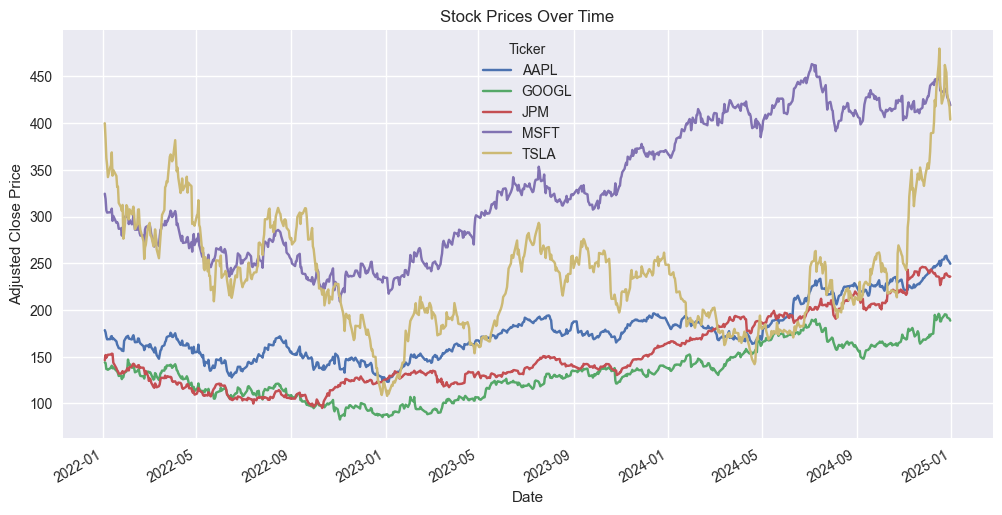

In [ ]:
# 12. Enhanced EDA Visualizations

# 12.1 Stock Prices Over Time
pivot_data.plot(figsize=(12,6))
plt.title("Stock Prices Over Time")
plt.ylabel("Adjusted Close Price")
plt.xlabel("Date")
plt.legend(title="Ticker")
plt.show()

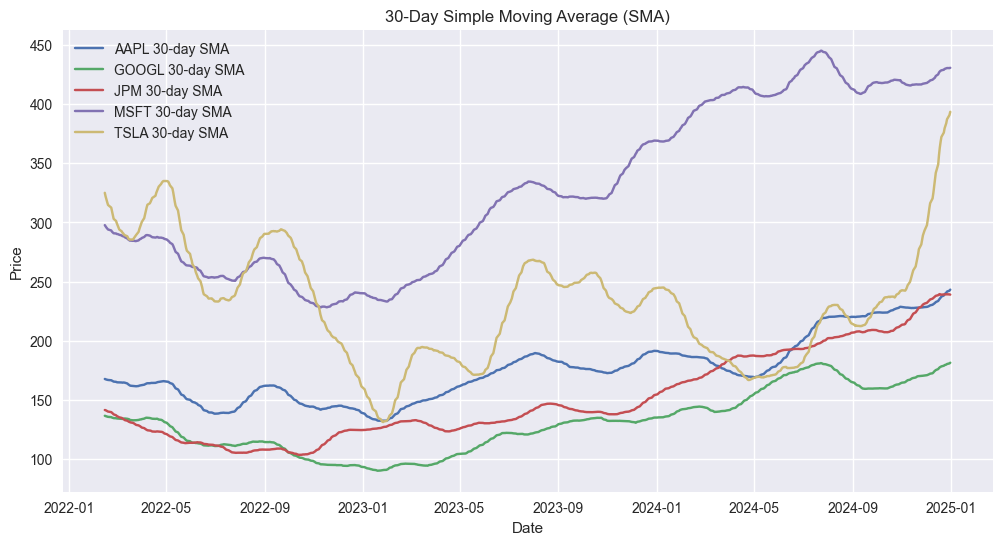

In [ ]:
# 12.2 Rolling Statistics (SMA example for all tickers)
rolling_window = 30
plt.figure(figsize=(12,6))
for ticker in pivot_data.columns:
    plt.plot(pivot_data[ticker].rolling(rolling_window).mean(), label=f"{ticker} {rolling_window}-day SMA")
plt.title(f"{rolling_window}-Day Simple Moving Average (SMA)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

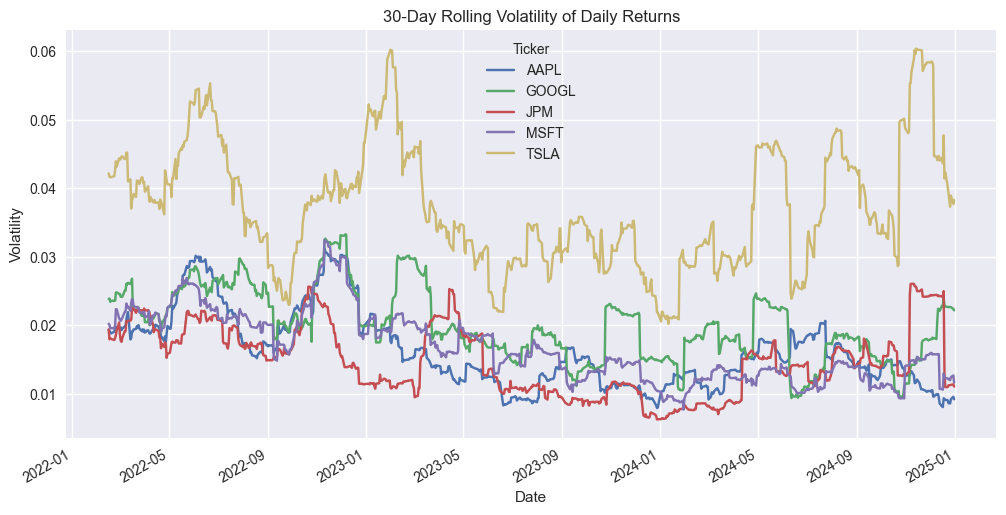

In [ ]:
# 12.3 Volatility (Rolling Std Dev of Returns)
rolling_vol = daily_returns.rolling(window=30).std()
rolling_vol.plot(figsize=(12,6))
plt.title("30-Day Rolling Volatility of Daily Returns")
plt.ylabel("Volatility")
plt.show()

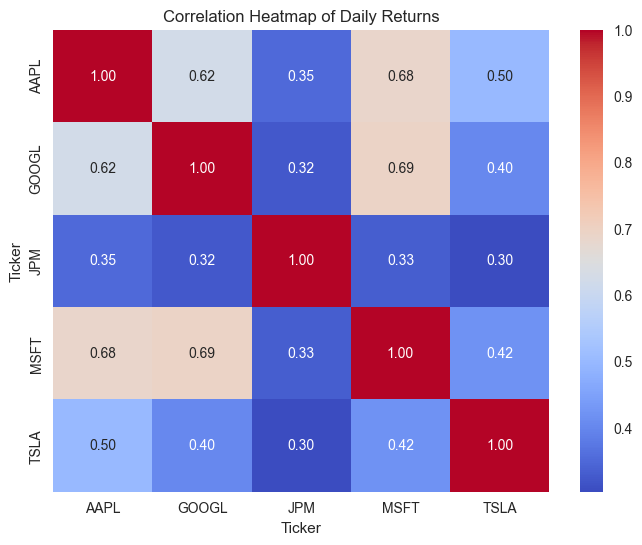

In [ ]:
# 12.4 Correlation Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(daily_returns.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Daily Returns")
plt.show()

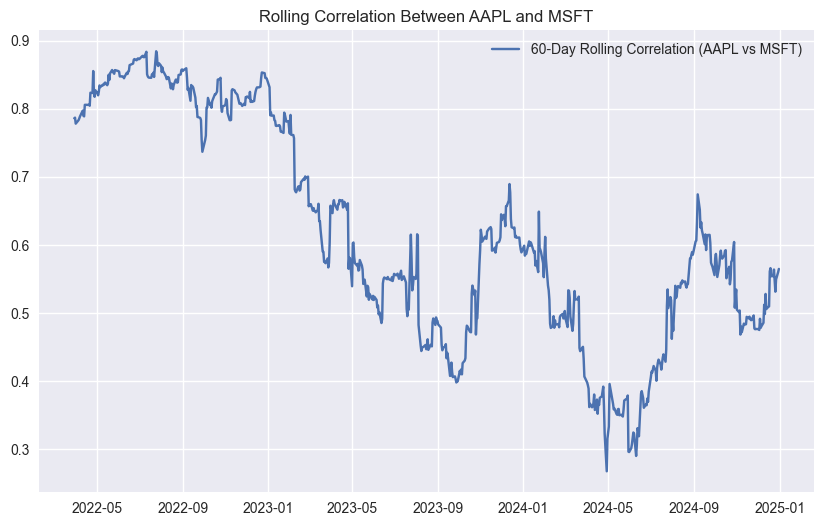

In [ ]:
# 12.5 Rolling Correlation Example (AAPL vs MSFT)
rolling_corr = daily_returns["AAPL"].rolling(60).corr(daily_returns["MSFT"])
plt.figure(figsize=(10,6))
plt.plot(rolling_corr, label="60-Day Rolling Correlation (AAPL vs MSFT)")
plt.title("Rolling Correlation Between AAPL and MSFT")
plt.legend()
plt.show()

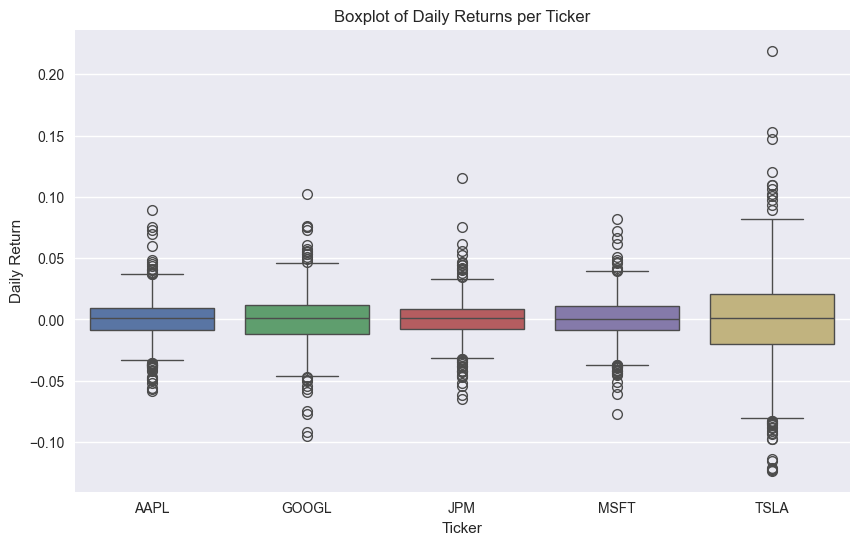

In [ ]:
# 12.6 Boxplots per ticker (showing spread & outliers)
plt.figure(figsize=(10,6))
sns.boxplot(data=daily_returns, orient="v")
plt.title("Boxplot of Daily Returns per Ticker")
plt.ylabel("Daily Return")
plt.show()

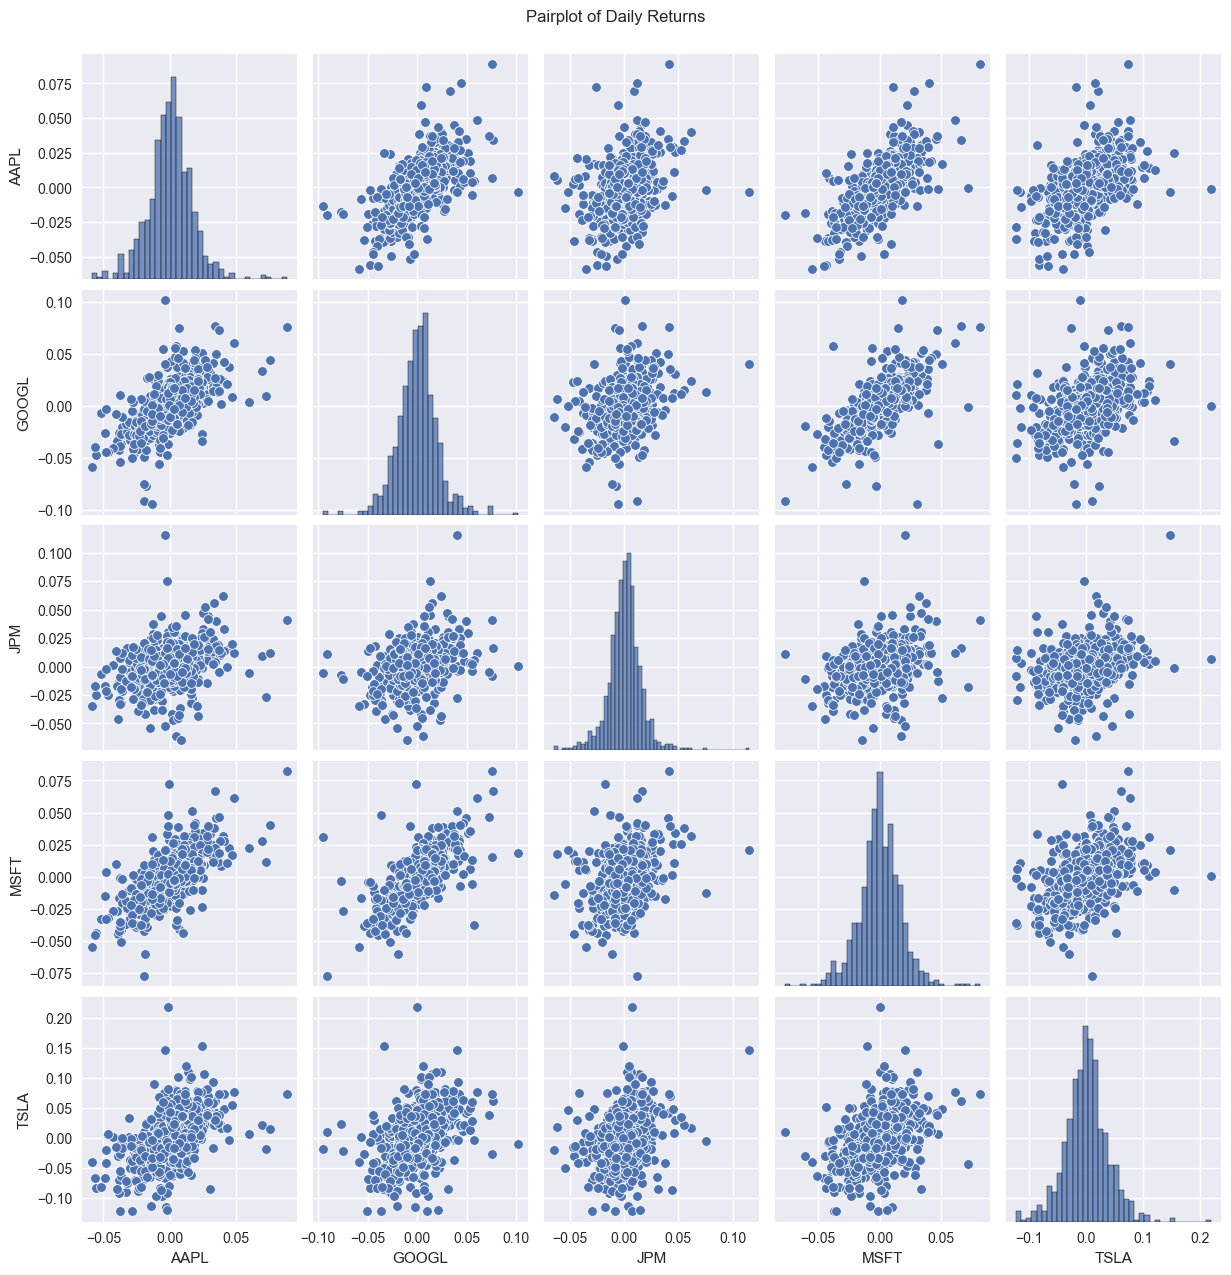

In [ ]:
# 12.7 Pairplot of returns for quick visual relationships
sns.pairplot(daily_returns.dropna())
plt.suptitle("Pairplot of Daily Returns", y=1.02)
plt.show()

In [ ]:
# 13. Save Cleaned Datasets
# Ensure directories exist
os.makedirs(os.path.dirname(CONFIG["output_long"]), exist_ok=True)
os.makedirs(os.path.dirname(CONFIG["output_wide"]), exist_ok=True)

# 13.1 Save long-format dataset (tidy)
cleaned_data.to_csv(CONFIG["output_long"], index=False)
print(f"✅ Long-format dataset saved: {CONFIG['output_long']}")

# 13.2 Save wide-format dataset (pivot)
pivot_data.to_csv(CONFIG["output_wide"])
print(f"✅ Wide-format dataset saved: {CONFIG['output_wide']}")

✅ Long-format dataset saved: data/cleaned_stock_data_long.csv
✅ Wide-format dataset saved: data/cleaned_stock_data_wide.csv


In [2]:
# function for making a simple moving function for a selected amount of days

def find_sma(df, window_no):
    df[f"SMA_{window_no}"] = df['Close'].rolling(window=window_no).mean()
    return df

# SMA for 30 days
find_sma(df, 30)

# SMA for 100 days
find_sma(df, 100)


NameError: name 'df' is not defined

In [3]:
def plot_price_sma_interactive(dates, prices, sma, save_folder="Graphs", filename="price_sma.html"):
    # Create folder if it doesn't exist
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    fig = go.Figure()

    # Closing price
    fig.add_trace(go.Scatter(
        x=dates,
        y=prices,
        mode='lines',
        name='Close Price',
        line=dict(color='green', width=2)
    ))

    # SMA line
    fig.add_trace(go.Scatter(
        x=dates,
        y=sma,
        mode='lines',
        name=sma.name,
        line=dict(color='purple', width=2, dash='dash')
    ))

    # Layout
    fig.update_layout(
        title='Stock Prices with SMA Overlay',
        xaxis_title='Date',
        yaxis_title='Closing Price',
        template='plotly_white',
        width=1200,
        height=600
    )

    # Show interactive chart
    fig.show()

    # Save interactive HTML
    save_path = os.path.join(save_folder, filename)
    fig.write_html(save_path)
    print(f"Interactive chart saved to: {save_path}")


# Example usage
#plot_price_sma_interactive(df["Date"], df["Close"], df["SMA_30"])

In [ ]:
def highlight_streaks_interactive(df, dates, prices, save_folder="Graphs", filename="highlighted_streaks.html"):
    """Highlight upward/downward price movements interactively and export as HTML."""
    
    # Ensure folder exists
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    
    df['Change'] = df[prices].diff().fillna(0)

    fig = go.Figure()

    # Loop through each segment (day-to-day)
    for i in range(1, len(df)):
        color = 'green' if df['Change'].iloc[i] > 0 else 'red'
        fig.add_trace(go.Scatter(
            x=df[dates].iloc[i-1:i+1],
            y=df[prices].iloc[i-1:i+1],
            mode='lines',
            line=dict(color=color, width=3),
            showlegend=False
        ))

    fig.update_layout(
        title="Close Price - Green for Up, Red for Down",
        xaxis_title="Date",
        yaxis_title="Close Price",
        template="plotly_white",
        width=1200,
        height=600
    )

    # Show interactive chart
    fig.show()

    # Save interactive HTML
    save_path = os.path.join(save_folder, filename)
    fig.write_html(save_path)
    print(f"Interactive chart saved to: {save_path}")


# Example usage
#highlight_streaks_interactive(df, 'Date', 'Close')


In [4]:
def annotate_profits_interactive(df, dates, prices, sma, save_folder="Graphs", filename="buy_sell_signals.html"):
    """Annotate buy/sell points for profit optimization and export interactive chart."""

    # Ensure folder exists
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    buy_signals = []
    sell_signals = []
    flag = -1  # -1: no position, 1: holding, 0: sold

    for i in range(len(df)):
        # Buy signal: Close crosses above SMA
        if df[prices].iloc[i] > df[sma].iloc[i]:
            if flag != 1:  # only buy if not already holding
                buy_signals.append(df[prices].iloc[i])
                sell_signals.append(np.nan)
                flag = 1
            else:
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)

        # Sell signal: Close crosses below SMA
        elif df[prices].iloc[i] < df[sma].iloc[i]:
            if flag != 0:  # only sell if holding
                buy_signals.append(np.nan)
                sell_signals.append(df[prices].iloc[i])
                flag = 0
            else:
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)
        else:
            buy_signals.append(np.nan)
            sell_signals.append(np.nan)

    df['Buy'] = buy_signals
    df['Sell'] = sell_signals

    fig = go.Figure()

    # Plot Close Price
    fig.add_trace(go.Scatter(
        x=df[dates],
        y=df[prices],
        mode='lines',
        name='Close Price',
        line=dict(color='blue', width=2)
    ))

    # Plot SMA line
    fig.add_trace(go.Scatter(
        x=df[dates],
        y=df[sma],
        mode='lines',
        name=sma,
        line=dict(color='orange', width=2, dash='dash')
    ))

    # Plot Buy signals
    fig.add_trace(go.Scatter(
        x=df[dates],
        y=df['Buy'],
        mode='markers',
        name='Buy Signal',
        marker=dict(symbol='triangle-up', color='green', size=12)
    ))

    # Plot Sell signals
    fig.add_trace(go.Scatter(
        x=df[dates],
        y=df['Sell'],
        mode='markers',
        name='Sell Signal',
        marker=dict(symbol='triangle-down', color='red', size=12)
    ))

    # Layout
    fig.update_layout(
        title="Stock Buy/Sell Signals Based on SMA Strategy",
        xaxis_title="Date",
        yaxis_title="Price",
        template="plotly_white",
        width=1300,
        height=600
    )

    # Show interactive chart
    fig.show()

    # Save interactive HTML
    save_path = os.path.join(save_folder, filename)
    fig.write_html(save_path)
    print(f"Interactive chart saved to: {save_path}")


# Example usage
#annotate_profits_interactive(df, "Date", "Close", "SMA_30")